# Cartpole Bayesian Sindy

The full cartpole equations are:

$$\ddot{x}=\frac{f-ml\ddot{\theta}\cos{\theta} +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x}}{m_c + m}$$

$$\ddot{\theta}=\frac{Mg\sin{\theta} -\cos{\theta}(f +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x})-\frac{M\mu_p\dot{\theta}}{ml}}{(1+k)Ml-ml\cos^2{\theta}}$$

After filling in constants, the equations "simplify" to:

$$
\ddot{x} = a - b\ddot{\theta}\cos{\theta} + b\dot{\theta}^2\sin{\theta} - c\dot{x}
$$

$$
\ddot{\theta} = \frac{d\sin{\theta}-f\cos{\theta}-j\dot{\theta}^2\sin{\theta}\cos{\theta} + l\dot{x}\cos{\theta} - k\dot{\theta}}{h - j\cos^2{\theta}}
$$


In [ ]:
---
execute:
    echo: true
code-fold: true
output: html
toc: true
fig-align: center
fontsize: 16px
format:
    html:
        embed-resources: true
---

In [2]:
using Turing, DifferentialEquations, StatsPlots, LinearAlgebra, Random

## Sim Data

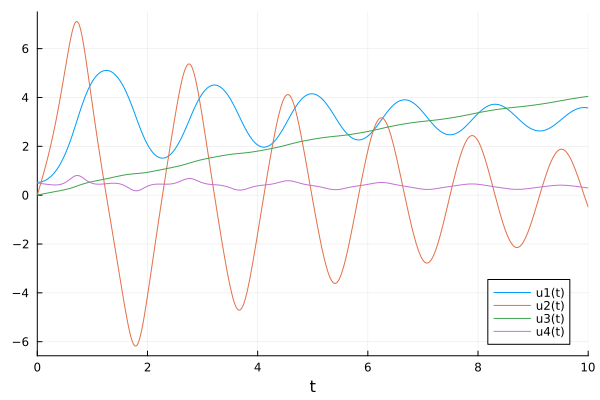

In [3]:
function cartpole!(du, u, p, t)
    # u = [theta, theta_d, x, x_d]

    # external force
    # force = -0.2+0.5*sin(6*t)
    force = 0

    # Parameters
    m1, m2, gravity, length, mu_c, mu_p, k_inertia = p

    # theta_d
    du[1] = u[2]

    # theta_dd
    du[2] = ((m1+m2)*gravity*sin(u[1])-cos(u[1])*(force+m2*length*(u[2]^2)*sin(u[1])-mu_c*u[4])-((m1+m2)*mu_p*u[2])/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(cos(u[1]))^2)

    # x_d
    du[3] = u[4]

    # x_dd
    du[4] = (force-m2*length*(du[2]*cos(u[1])-(u[2]^2)*sin(u[1]))-mu_c*u[4]) / (m1+m2)
end

# Parameters 
p = (1.0, 0.1, 9.8, 0.5, 0.05, 0.01, 1/3)

# Initial conditions
u0 = [0.524, 0.0, 0.0, 0.5]  # 30 degrees, 2 m/s to the right

tspan = (0.0,10.0)
probCart = ODEProblem(cartpole!,u0,tspan,p)

# Solve
sol = solve(probCart, Tsit5())

X = Array(sol)
t = sol.t
DX = Array(sol(sol.t,Val{1}))[[2], :]

plot(sol)

### Generate dummy data for estimation

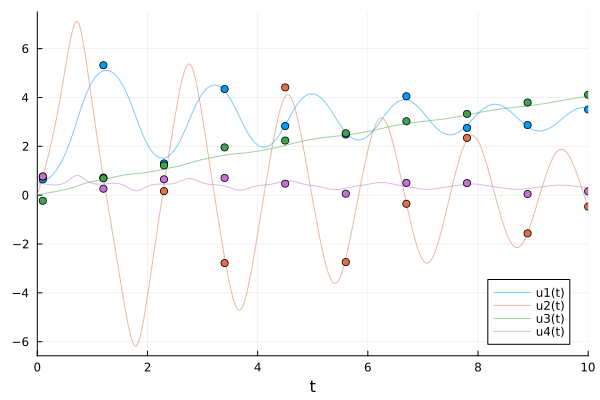

In [4]:
t = collect(range(0.1, stop=10, length=10))

odedata = Array(solve(probCart, saveat=t))
odedata = odedata + 0.2 * randn(size(odedata))
plot(sol; alpha=0.5)
scatter!(t, odedata'; color=[1 2 3 4], label="")


## Parameter Estimation

The cartpole system is more complicated than the pendulum for several reasons:

* 2 Equations to solve
* $\ddot{\theta}$ equation is super complex, can only roughly approximate

I'm especially interested to see how close $\ddot{\theta}$ can be approximated, and if the approximation holds up to a new starting configuration.

One of the hardest decisions is which set of basis functions to use?

* $\ddot{x}$ is a function of 4 variables: $\theta, \dot{\theta}, \ddot{\theta}, and \dot{x}$.
* $\ddot{\theta}$ is a function of 4 variables: $\theta, \dot{\theta}, and \dot{x}$.

I will start with 1st and 2nd powers and simple interactions of all terms, and use $sin(\theta)$ in place of $\theta$


In [5]:
#| output: false
function cartpoleSindy!(du, u, p, t)
    # u = [theta, theta_d, x, x_d]

    θ, θ̇, x, ẋ = u

    # theta_d and x_d
    du[1] = θ̇
    du[3] = ẋ

    # theta_dd
    θ̈ = (p[1]*sin(θ) +
         p[2]*θ̇ + 
         p[3]*ẋ +
         p[4]*θ̇ *sin(θ)+ 
         p[5]*ẋ *sin(θ)+ 
         p[6]*ẋ *θ̇ + 
         p[7]*sin(θ)^2+ 
         p[8]*θ̇ ^2+ 
         p[9]*ẋ^2)
    du[2] = θ̈ 

    # x_dd
    du[4] = (p[10]*sin(θ) +
             p[11]*θ̇ + 
             p[12]*θ̈  +
             p[13]*ẋ +
             p[14]*θ̇ *sin(θ)+ 
             p[15]*ẋ *sin(θ)+ 
             p[16]*ẋ *θ̇+ 
             p[17]*θ̈ *sin(θ)+ 
             p[18]*ẋ *θ̈ + 
             p[19]*θ̈  *θ̇+ 
             p[20]*sin(θ)^2+ 
             p[21]*θ̇ ^2+ 
             p[22]*θ̈  ^2+ 
             p[23]*ẋ^2)
end

cartpoleProb = ODEProblem(cartpoleSindy!, u0, tspan, [0.0 for _ in 1:23])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 4-element Vector{Float64}:
 0.524
 0.0
 0.0
 0.5

In [6]:
#| output: false
@model function fitCartpoleLaplace(data, ::Type{T} = Float64) where {T <: Real}

    # Prior distributions
    priors = [Laplace(0.0, 1.0) for _ in 1:23]
    theta = Vector{T}(undef, length(priors))
    syms = [Turing.@varname(theta[i]) for i in 1:length(priors)]
    for i in 1:length(priors)
        theta[i] ~ NamedDist(priors[i], syms[i])
    end

    σ ~ InverseGamma(2, 3)

    p = convert.(T, theta)
    u0 = convert.(T, cartpoleProb.u0)

    # Simulate model
    predicted = solve(cartpoleProb, Tsit5(); p=p, saveat=t)
    predicted_dense = solve(cartpoleProb, Tsit5(); p=p)
    failure = size(predicted, 2) < length(t)

    if failure
        Turing.@addlogprob! -Inf
        return
    end

    # Observations
    for i in 1:length(t)
        data[:, i] ~ MvNormal(predicted[:, i], σ^2 * I)
    end

    # return nothing
    return (; theta, predicted_dense)
end


fitCartpoleLaplace (generic function with 3 methods)

In [7]:
#| output: false
modelHorse = fitCartpoleLaplace(odedata)

chain5 = sample(modelHorse, NUTS(0.65; init_ϵ=0.01), MCMCSerial(), 500, 2; progress=true)


Sampling (Chain 1 of 2)   0%|█                          |  ETA: N/A
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are 

Sampling (Chain 1 of 2)   1%|█                          |  ETA: 6:02:04
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.638904969602685. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.638904969602685. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.639183800205528. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.087877962663332. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.087877962663332. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.08953723237985. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.08953723237985. Aborting. There is either

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.882359368074573. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.882359368074573. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.882966016814226. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.882966016814226. Aborting. There is eith

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.079122778975492. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.079122778975492. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.075660313731797. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.075660313731797. Aborting. There is eith

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.2470761437709266. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.2470761437709266. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.2453562866565013. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.2453562866565013. Aborting. There is 

Sampling (Chain 1 of 2)   6%|██                         |  ETA: 1:09:58
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.327597345381713. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.327597345381713. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.33075908088721. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.050542605327858. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.050542605327858. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.0507197595715527. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.0507197595715527. Aborting. There is ei

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5966666335308805. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5966666335308805. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.596662638528193. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.596662638528193. Aborting. There is ei

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching alg

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.24028987476652075. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.24028987476652075. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.24028948700477115. Aborting. There is either an error in your model specification or the true soluti

Sampling (Chain 1 of 2)  11%|███                        |  ETA: 1:06:07
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.5686613319316605. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.5686613319316605. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.568652603425062. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtm

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.6610657068272078. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <=

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.8493473603199257. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.8493473603199257. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.0552884423961697. Aborting. There is either an error in your model specification or the true solution 

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.8991378419856917. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  14%|████                       |  ETA: 0:58:04
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9182901585400048. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9182901585400048. Aborting. Th

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.464467073957355. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.46548625497718. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.46548625497718. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true,

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9656509865637245. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9656509865637245. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9656456390173572. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9656456390173572. Aborting. There is 

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.4658448230204777. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.4658448230204777. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.4659182082529296. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.4659182082529296. Aborting. There is 

Sampling (Chain 1 of 2)  18%|█████                      |  ETA: 0:50:58
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.439247342474283. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.439247342474283. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.439128242915344. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.142102039342383. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.142102039342383. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.1421542247692016. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.1421542247692016. Aborting. There is ei

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.228623973986629. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.228623973986629. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.2286239075314387. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.2286239075314387. Aborting. There is ei

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5553722435535444. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5553722435535444. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5553823190095503. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5553823190095503. Aborting. There is 

Sampling (Chain 1 of 2)  22%|███████                    |  ETA: 0:49:28
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5885944648488892. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5885944648488892. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5885897684519609. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dt

Sampling (Chain 1 of 2)  23%|███████                    |  ETA: 0:47:34
Sampling (Chain 1 of 2)  24%|███████                    |  ETA: 0:46:56
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.997930585348241. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.997930585348241. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.997747412481683. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\in

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  25%|███████                    |  ETA: 0:43:36
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.7949868171342146. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.7949868171342146. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.7949816446527257. Aborting. Th

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.620024332311611. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.620024332311611. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.620052952936432. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.620052952936432. Aborting. There is eith

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching alg

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.39235365219839025. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.39235365219839025. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.3923541754156695. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.3923541754156695. Aborting. There i

Sampling (Chain 1 of 2)  29%|████████                   |  ETA: 0:47:07
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.82224150584521. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.82224150584521. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.819815147661821. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1

Sampling (Chain 1 of 2)  30%|████████                   |  ETA: 0:45:21
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.5097066811407456. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.5097066811407456. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.5108678026093534. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dt

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching alg

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.6213208289826169. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.6213208289826169. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.6211973300535962. Aborting. There is either an error in your model specification or the true solution 

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.544396381057622. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.544396381057622. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.544269800711346. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.544269800711346. Aborting. There is eith

Sampling (Chain 1 of 2)  33%|█████████                  |  ETA: 0:46:27
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.456863820539466. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.456863820539466. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.456032972065069. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin

Sampling (Chain 1 of 2)  34%|██████████                 |  ETA: 0:44:17
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.55702044641561. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.55702044641561. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.557837728444214. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.92919734677617. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.92919734677617. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.929484472492774. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.929484472492774. Aborting. There is either

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching alg

Sampling (Chain 1 of 2)  37%|███████████                |  ETA: 0:42:26
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.3842728209804345. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.3842728209804345. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.3835557222780204. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dt

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.10176079125652548. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.10176079125652548. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.10175568644314194. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.10175568644314194. Aborting. There

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, tr

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ 

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching alg

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.3010212467646385. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.3010212467646385. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.299641687634707. Aborting. There is either an error in your model specification or the true solution i

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9026104854398407. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9026104854398407. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9025418977121111. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9025418977121111. Aborting. There is 

Sampling (Chain 1 of 2)  43%|████████████               |  ETA: 0:58:55
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.212085171151441. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.212085171151441. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.2121373807414573. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmi

Sampling (Chain 1 of 2)  44%|████████████               |  ETA: 0:56:09
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.4974134884774997. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.4974134884774997. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.496871600927581. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtm

Sampling (Chain 1 of 2)  45%|█████████████              |  ETA: 0:54:24
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.999949620223504. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.999949620223504. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.999625133236176. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.374762871148588. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.374762871148588. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.375001442646739. Aborting. There is either an error in your model specification or the true solution is 

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.819342248414859. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.819342248414859. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.816047695055145. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.816047695055145. Aborting. There is eith

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.118330006445831. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.118330006445831. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.1232282973297707. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.1232282973297707. Aborting. There is ei

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.891226074912565. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.891226074912565. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.891215029316585. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.891215029316585. Aborting. There is eith

Sampling (Chain 1 of 2)  51%|██████████████             |  ETA: 0:43:59
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.35009215590274. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.35009215590274. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.349090256784422. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, tr

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching alg

Sampling (Chain 1 of 2)  54%|███████████████            |  ETA: 0:42:47
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you 

Sampling (Chain 1 of 2)  55%|███████████████            |  ETA: 0:42:25Excessive output truncated after 524374 bytes.

Chains MCMC chain (500×36×2 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 2
Samples per chain = 500
Wall duration     = 12345.98 seconds
Compute duration  = 12340.75 seconds
parameters        = theta[1], theta[2], theta[3], theta[4], theta[5], theta[6], theta[7], theta[8], theta[9], theta[10], theta[11], theta[12], theta[13], theta[14], theta[15], theta[16], theta[17], theta[18], theta[19], theta[20], theta[21], theta[22], theta[23], σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

    theta[1]    2.3733    1.5397     0.0487    0.2211   14.8460    1.1691      ⋯
    theta[2]   -0.6667    0.8906     0.0282    0.0935   48.1714    

In [8]:
#| output: false
# Save/read samples
path = "../Data/chain-cartpole-hs-hard-laplace.jls"
if @isdefined chain5
    write(path, chain5)
else
    chain5 = read(path, Chains)
end

In [9]:
#| output: false
using DataFramesMeta

finnish_chain = generated_quantities(modelHorse, MCMCChains.get_sections(chain5, :parameters))
finnish_df = reduce(vcat, DataFrame(finnish_chain[:, i]) for i in 1:size(finnish_chain, 2))


1000×2 DataFrame
  Row │ theta                              predicted_dense                   
      │ Array…                             ODESolution…                      
──────┼──────────────────────────────────────────────────────────────────────
    1 │ [-0.325717, -0.677642, -0.216531…  ODESolution{Float64, 2, Vector{V…
    2 │ [0.366727, -0.222721, -0.373896,…  ODESolution{Float64, 2, Vector{V…
    3 │ [0.196949, -0.207207, -0.275407,…  ODESolution{Float64, 2, Vector{V…
    4 │ [0.219637, -0.141989, -0.282264,…  ODESolution{Float64, 2, Vector{V…
    5 │ [0.232924, -0.372179, -0.466472,…  ODESolution{Float64, 2, Vector{V…
    6 │ [0.180341, -0.515272, -0.920943,…  ODESolution{Float64, 2, Vector{V…
    7 │ [0.141917, -0.552773, -0.879459,…  ODESolution{Float64, 2, Vector{V…
    8 │ [0.458113, 0.0711759, -0.839272,…  ODESolution{Float64, 2, Vector{V…
  ⋮   │                 ⋮                                  ⋮
  994 │ [3.26412, -0.196596, -1.06034, 0…  ODESolution{Float64, 2, Vector{V…
  995 │ [3.73638, 0.0164862, -1.21689, 0…  ODESolution{Float64, 2, Vector{V…
  996 │ [3.73638, 0.0164862, -1.21689, 0…  ODESolution{Float64, 2, Vector{V…
  997 │ [3.67808, -0.219831, -1.2227, 0.…  ODESolution{Float64, 2, Vector{V…
  998 │ [3.63673, -0.257259, -1.21265, 0…  ODESolution{Float64, 2, Vector{V…
  999 │ [3.49608, -0.135622, -1.33432, 0…  ODESolution{Float64, 2, Vector{V…
 1000 │ [3.69333, -0.171151, -1.14794, 0…  ODESolution{Float64, 2, Vector{V…
                                                             985 rows omitted

In [10]:
#| output: false
using DataFrames

# Extract coefficient samples

# Clean data from generated quantites
samples = size(finnish_chain, 1)
var_str = [
    "\$sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{θ} \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} \\rightarrow \\ddot{θ}\$",
    "\$\\dot{θ} * sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} * sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{θ}\$",
    "\$sin(θ)^2 \\rightarrow \\ddot{θ}\$",
    "\$\\dot{θ}^2 \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x}^2 \\rightarrow \\ddot{θ}\$",
    "\$sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} \\rightarrow \\ddot{x}\$",
    "\$\\dot{θ} * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ} * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ} * \\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$sin(θ)^2 \\rightarrow \\ddot{x}\$",
    "\$\\dot{θ}^2 \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ}^2 \\rightarrow \\ddot{x}\$",
    "\$\\dot{x}^2 \\rightarrow \\ddot{x}\$",
]
beta1 = DataFrame([finnish_chain[i, 1][:theta] for i in 1:samples], :auto)
beta1[!,:var] = var_str
beta1[!,:chain] = [1 for _ in 1:size(beta1)[1]]
beta1 = DataFrames.stack(beta1, 1:samples)
beta2 = DataFrame([finnish_chain[i, 2][:theta] for i in 1:samples], :auto)
beta2[!,:var] = var_str
beta2[!,:chain] = [2 for _ in 1:size(beta2)[1]]
beta2 = DataFrames.stack(beta2, 1:samples)
beta = vcat(beta1, beta2)
beta

23000×4 DataFrame
   Row │ var                                chain  variable  value      
       │ String                             Int64  String    Float64    
───────┼────────────────────────────────────────────────────────────────
     1 │ $sin(θ) \\rightarrow \\ddot{θ}$        1  x1        -0.325717
     2 │ $\\dot{θ} \\rightarrow \\ddot{θ}$      1  x1        -0.677642
     3 │ $\\dot{x} \\rightarrow \\ddot{θ}$      1  x1        -0.216531
     4 │ $\\dot{θ} * sin(θ) \\rightarrow …      1  x1        -0.18182
     5 │ $\\dot{x} * sin(θ) \\rightarrow …      1  x1         2.77517
     6 │ $\\dot{x} * \\dot{θ} \\rightarro…      1  x1         0.269151
     7 │ $sin(θ)^2 \\rightarrow \\ddot{θ}$      1  x1         0.969223
     8 │ $\\dot{θ}^2 \\rightarrow \\ddot{…      1  x1        -1.03066
   ⋮   │                 ⋮                    ⋮       ⋮          ⋮
 22994 │ $\\ddot{θ} * sin(θ) \\rightarrow…      2  x500      -0.902771
 22995 │ $\\dot{x} * \\dot{θ} \\rightarro…      2  x500       0.608844
 22996 │ $\\ddot{θ} * \\dot{θ} \\rightarr…      2  x500       2.17491
 22997 │ $sin(θ)^2 \\rightarrow \\ddot{x}$      2  x500      -0.0992257
 22998 │ $\\dot{θ}^2 \\rightarrow \\ddot{…      2  x500      -0.120547
 22999 │ $\\ddot{θ}^2 \\rightarrow \\ddot…      2  x500       0.456227
 23000 │ $\\dot{x}^2 \\rightarrow \\ddot{…      2  x500      -0.999632
                                                      22985 rows omitted

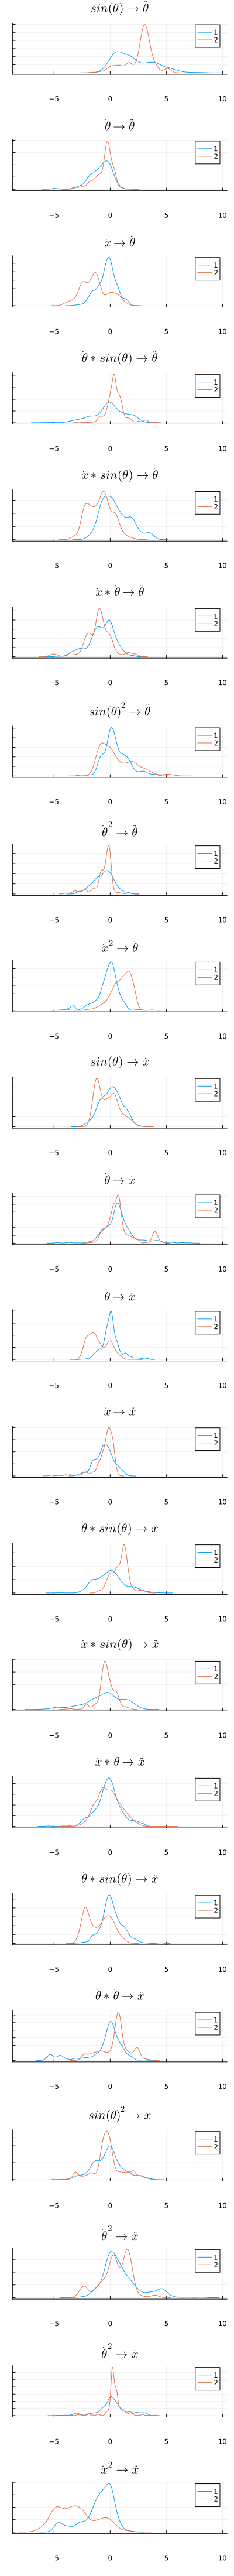

In [11]:
#| output: false
#| echo: false
gdf = groupby(beta, :var)
plot_list = []
for ((k,), v) in pairs(gdf)
    push!(plot_list, @df v density(:value, group=(:chain), title=k))
end

plot(plot_list..., layout=(length(plot_list), 1), size=(400, 200 * length(plot_list)), link = :x)
    


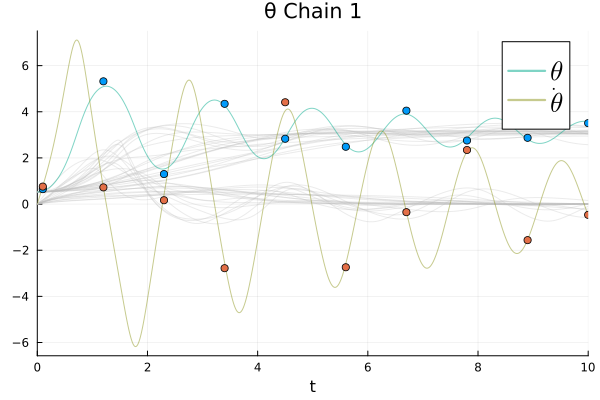

In [12]:
#| output: false
#| echo: false
plot(; title="θ Chain 1", legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 1:25:500
    plot!(all_sol[i], idxs=[1, 2]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[1, 2]; alpha=0.5, linewidth=1, legend=true, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
scatter!(t, odedata[1:2, :]'; color=[1 2], label="")


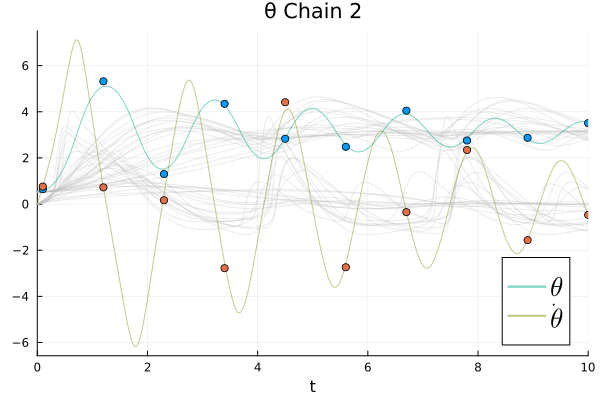

In [13]:
#| output: false
#| echo: false
plot(; title="θ Chain 2", legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 501:25:1000
    plot!(all_sol[i], idxs=[1, 2]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[1, 2]; alpha=0.5, linewidth=1, legend=true, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
scatter!(t, odedata[1:2, :]'; color=[1 2], label="")


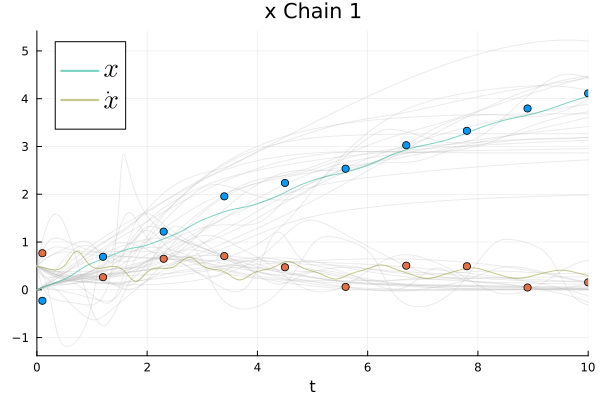

In [14]:
#| output: false
#| echo: false
plot(; title="x Chain 1", legendfontsize=18)
all_sol = finnish_df.predicted_dense
# for i in 1:size(finnish_df, 1)
for i in 1:25:500
    plot!(all_sol[i], idxs=[3, 4]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[3, 4]; alpha=0.5, linewidth=1, label=["\$x\$" "\$\\dot{x}\$"])
scatter!(t, odedata[3:4, :]'; color=[1 2], label="")


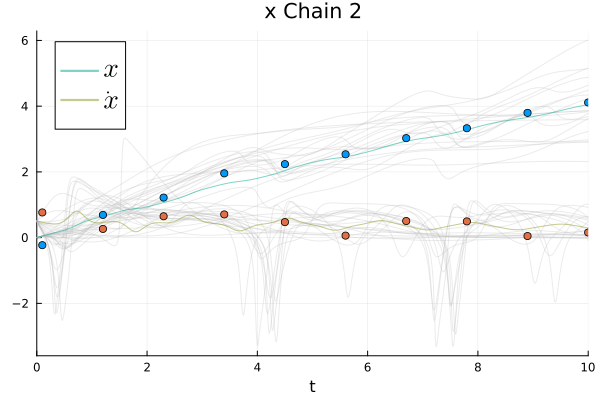

In [15]:
#| output: false
#| echo: false

plot(; title="x Chain 2", legendfontsize=18)
all_sol = finnish_df.predicted_dense
# for i in 1:size(finnish_df, 1)
for i in 501:25:1000
    plot!(all_sol[i], idxs=[3, 4]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[3, 4]; alpha=0.5, linewidth=1, label=["\$x\$" "\$\\dot{x}\$"])
scatter!(t, odedata[3:4, :]'; color=[1 2], label="")


## Summary

The chains found slightly different solutions; both were pretty bad. They pick up on the general trends in x, but aren't able to do so with $\theta$